In [1]:
import os
import sys
import time
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.backend as K
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score
from collections import OrderedDict, Counter
from tensorflow.python.ops import gen_array_ops
from keras.layers import Dense, Dropout, Flatten
from names import Names as n

In [2]:
from scipy.stats import gaussian_kde
from descartes import PolygonPatch
import alphashape
from sklearn.cluster import KMeans

In [3]:
from pathlib import Path
from harness.test_harness_class import TestHarness
from harness.th_model_instances.hamed_models.random_forest_classification import random_forest_classification
from harness.th_model_instances.hamed_models.weighted_logistic import weighted_logistic_classifier

In [4]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)
matplotlib.use("tkagg")
warnings.filterwarnings('ignore')

In [25]:
%load_ext autoreload
%autoreload 2
from notebook_functions import *
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
col_idx = OrderedDict([(n.label, 0), ("inducer_concentration", 1), ("timepoint", 2), ("percent_live", 3)])

# Read in Data and Prepare Variables

In [7]:
duke_v2_with_strateos_80 = pd.read_csv("experiment_data/processed/duke_v2_with_strateos_80.csv")


In [8]:
duke_stained = duke_v2_with_strateos_80.loc[duke_v2_with_strateos_80["stain"] == 1]
duke_unstained = duke_v2_with_strateos_80.loc[duke_v2_with_strateos_80["stain"] == 0]

In [9]:
features_unstained = n.morph_cols
features_stained_duke = n.morph_cols + ["YL1-A", "YL1-H", "YL1-W"]

In [10]:
print(features_unstained)
print(features_stained_duke)

['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W']
['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'YL1-A', 'YL1-H', 'YL1-W']


In [11]:
duke_stained

,inducer_concentration,timepoint,stain,FSC-A,SSC-A,YL1-A,FSC-H,SSC-H,YL1-H,FSC-W,SSC-W,YL1-W,percent_live,source
0,0.0,0.0,1.0,6.020600,6.020600,4.900930,5.764440,5.411980,2.940520,3.00988,3.00988,0.0,78.633333,duke_v2
1,0.0,0.0,1.0,5.389450,4.592750,2.597700,5.371090,4.594220,2.414970,1.96379,1.87506,0.0,78.633333,duke_v2
2,0.0,0.0,1.0,5.450140,4.883100,2.403120,5.415370,4.848330,2.233000,1.94448,1.89763,0.0,78.633333,duke_v2
3,0.0,0.0,1.0,5.644360,5.118360,2.866290,5.583750,5.063450,2.638490,1.95424,1.94448,0.0,78.633333,duke_v2
4,0.0,0.0,1.0,5.258560,4.683070,1.806180,5.259830,4.681420,2.181840,1.90309,1.86332,0.0,78.633333,duke_v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704061,80.0,6.0,1.0,4.121822,2.887617,0.000000,3.756712,2.685742,1.732394,0.00000,0.00000,0.0,0.000000,strateos
1704062,80.0,6.0,1.0,4.981198,0.000000,0.000000,3.822037,2.838849,2.025306,0.00000,0.00000,0.0,0.000000,strateos
1704063,80.0,6.0,1.0,5.295772,0.000000,0.000000,3.789792,2.615950,2.086360,0.00000,0.00000,0.0,0.000000,strateos
1704064,80.0,6.0,1.0,5.471633,0.000000,0.000000,3.768120,2.840106,2.127105,0.00000,0.00000,0.0,0.000000,strateos


# Generate RF Labels for Stained data but only using Morph Features

In [12]:
df_duke_stained_morph, \
X_duke_stained_morph, \
Y_duke_stained_morph = generate_rf_labels_from_conditions(duke_stained,
                                                          features_unstained,
                                                live_conditions=[{'inducer_concentration': 0.0, 'timepoint': 0.0},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 0.5},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 3.0},
                                                                 {'inducer_concentration': 0.0, 'timepoint': 6.0}],
                                                dead_conditions=None
                                                         )

Conditions designated as Live: [{'inducer_concentration': 0.0, 'timepoint': 0.0}, {'inducer_concentration': 0.0, 'timepoint': 0.5}, {'inducer_concentration': 0.0, 'timepoint': 3.0}, {'inducer_concentration': 0.0, 'timepoint': 6.0}]
Conditions designated as Dead: [{'inducer_concentration': 20.0, 'timepoint': 6.0}, {'inducer_concentration': 80.0, 'timepoint': 6.0}]


----------------------------------------------------------------------------------------------------
Starting run of model random_forest_classification at time 15:15:43
Starting Classification training...
Training time was: 32.14 seconds
Testing time was: 4.07 seconds
Prediction time of untested data was: 25.586102962493896
Run finished at 15:16:51. Total run time = 68.33 seconds
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




# All Plots/Models use Stained data, but models only use morph features

**Replacing CFU percent_live values for 0% ethanol at time 0.5 and 1.0 with 100% before feeding into the model**

In [13]:
Y_duke_stained_morph.loc[(Y_duke_stained_morph[n.inducer_concentration] == 0.0) & 
                             (Y_duke_stained_morph[n.timepoint].isin([0.5, 1.0, 5.0])), n.percent_live] = 100.0
# Y_duke_stained_morph


Model Boosting took 323.0318388938904 seconds
Training Accuracy = 86.55%
Counter({1: 588304, 0: 279809})
Instructions for updating:
Please use `model.predict()` instead.


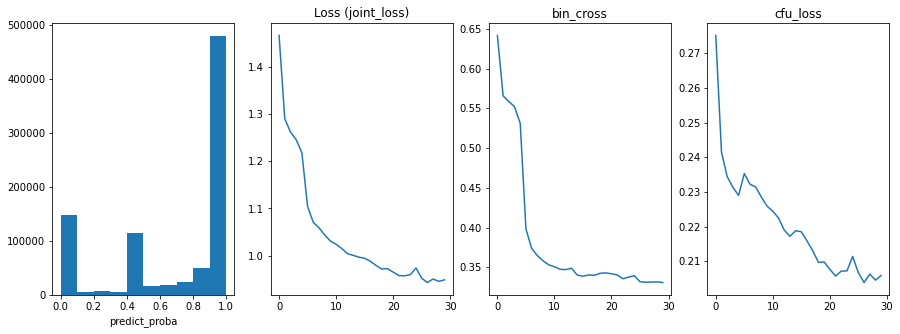

In [14]:
cr_duke_stained_morph, \
pl_duke_stained_morph = run_model(model_function=booster_model_v2, lr=0.001,
                                      loss = joint_loss_wrapper(3), metrics = [bin_cross, cfu_loss],
                                      X = X_duke_stained_morph, Y = Y_duke_stained_morph, 
                                      epochs = 30, batch_size = 2048,
                                      verbose = False, shuffle = True, plot_type="line")

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done

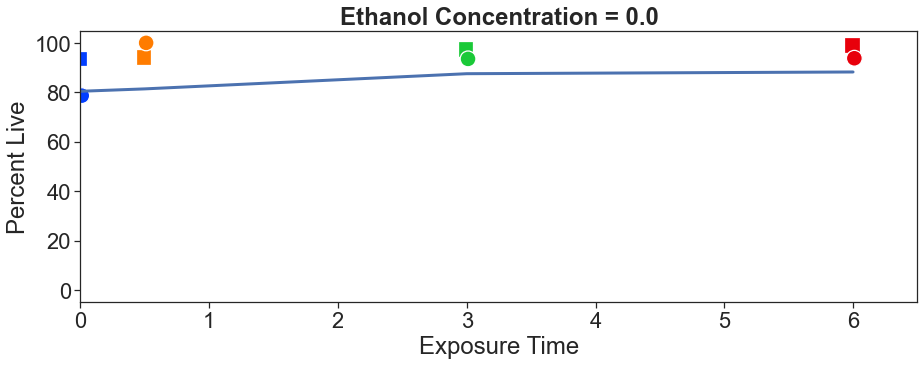

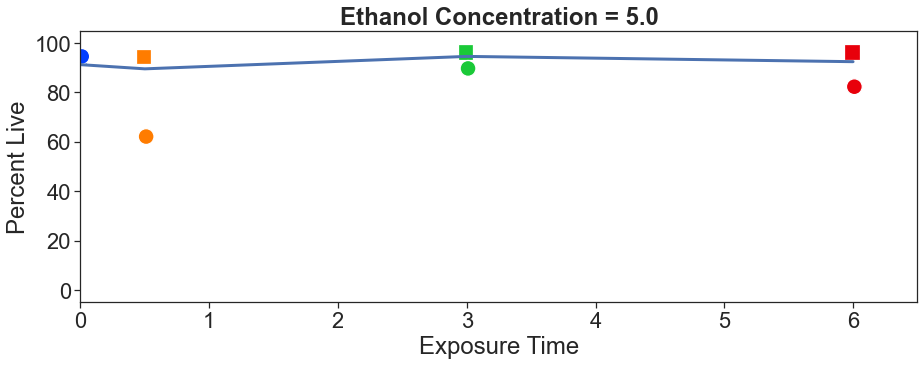

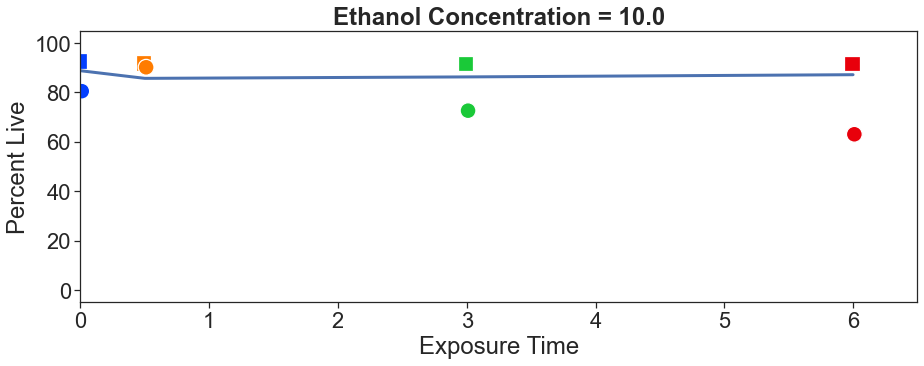

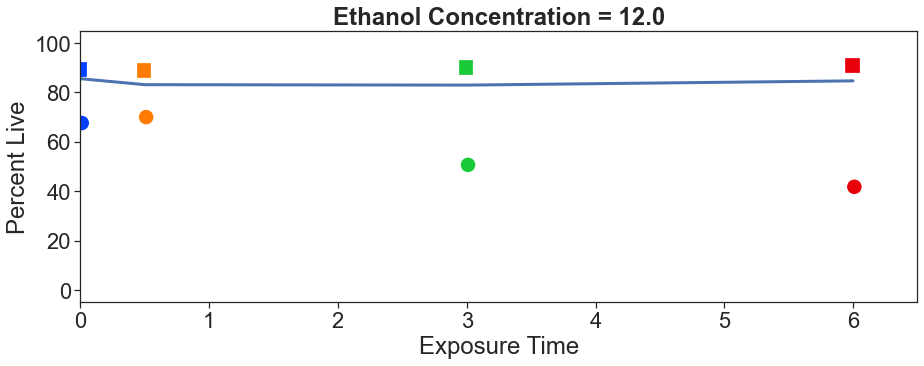

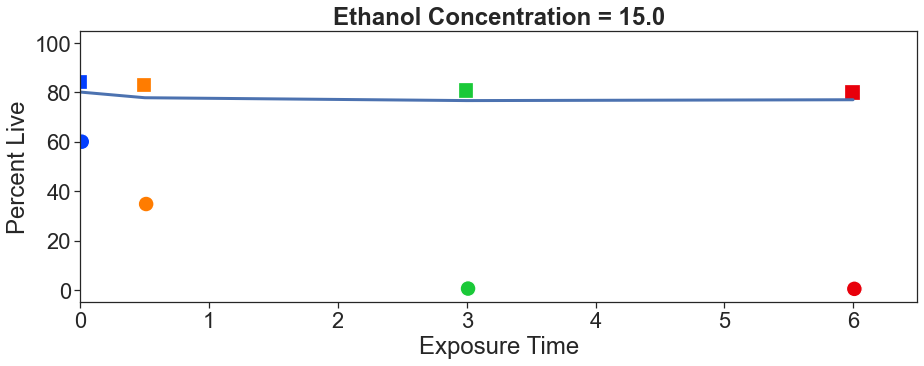

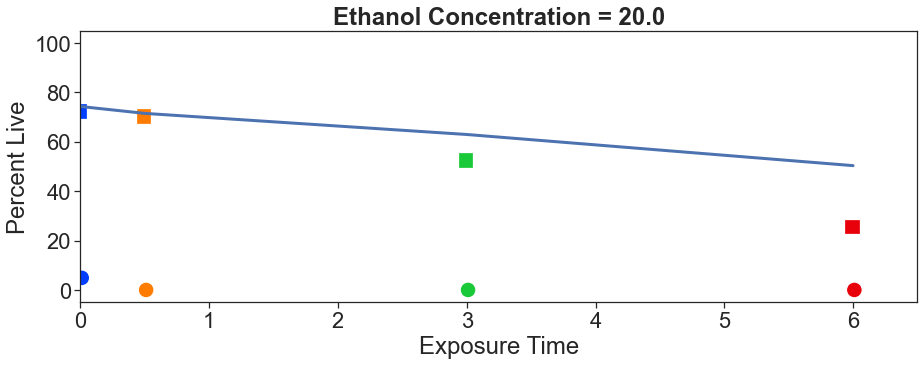

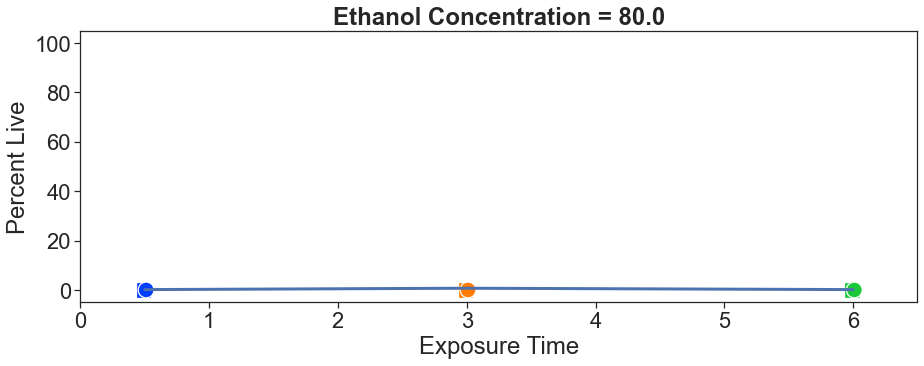

In [15]:
plot_per_cond(cr_duke_stained_morph)

In [16]:
info_duke_stained_morph = get_all_run_info(df_duke_stained_morph, 
                                               X_duke_stained_morph,
                                               pl_duke_stained_morph,
                                               append_df_cols=["YL1-A", "YL1-H", "YL1-W"])

[autoreload of notebook_functions failed: Traceback (most recent call last):
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done

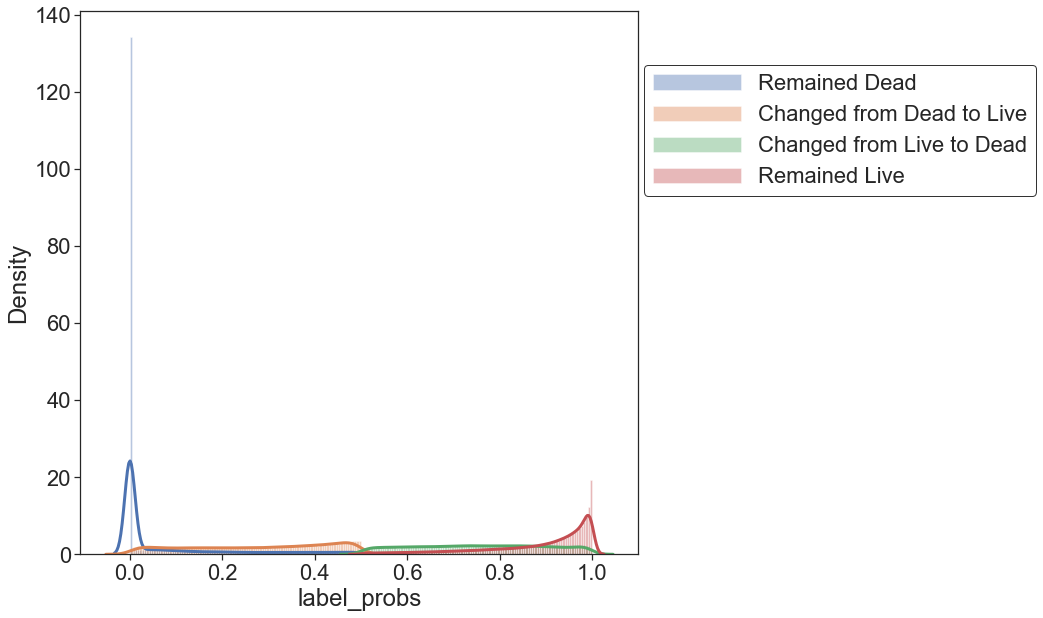

In [17]:
plot_prob_changes(info_duke_stained_morph, None)

# Calculate KDEs to get point density

In [18]:
conc_df_all = get_conc_df_with_kde_values(run_info=info_duke_stained_morph,
                                          conc="all",
                                          features=features_stained_duke,
                                          cc="YL1-H")

# Scatter + KDE Plots

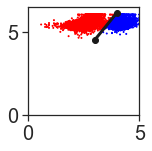

% of AutoGater live preds above SOA line: 90.2246694537915


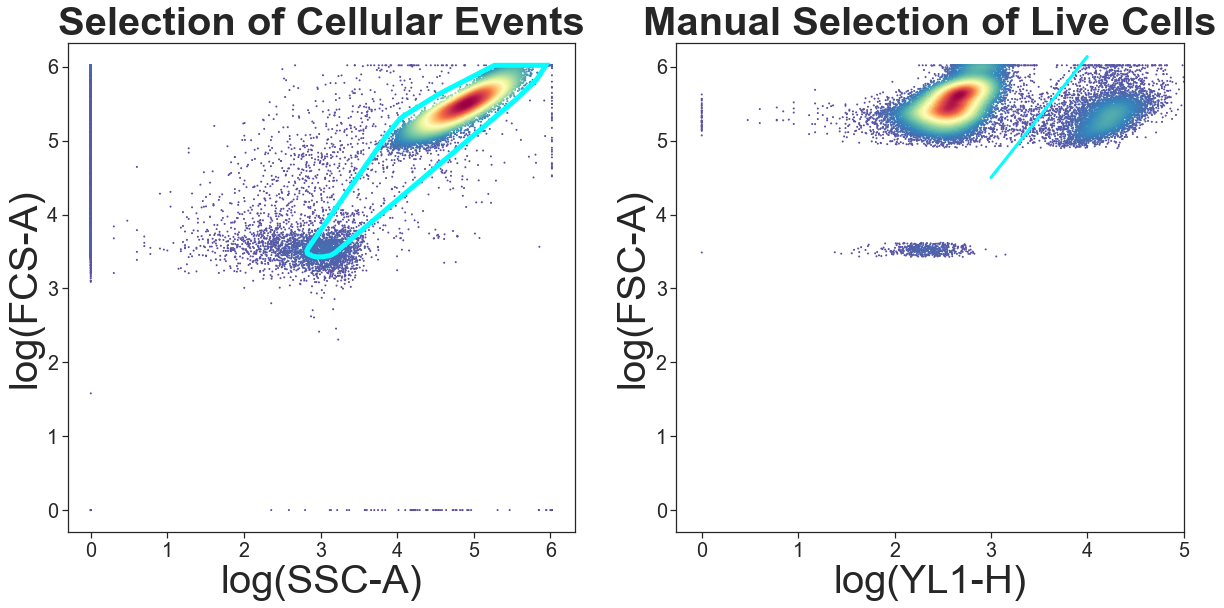

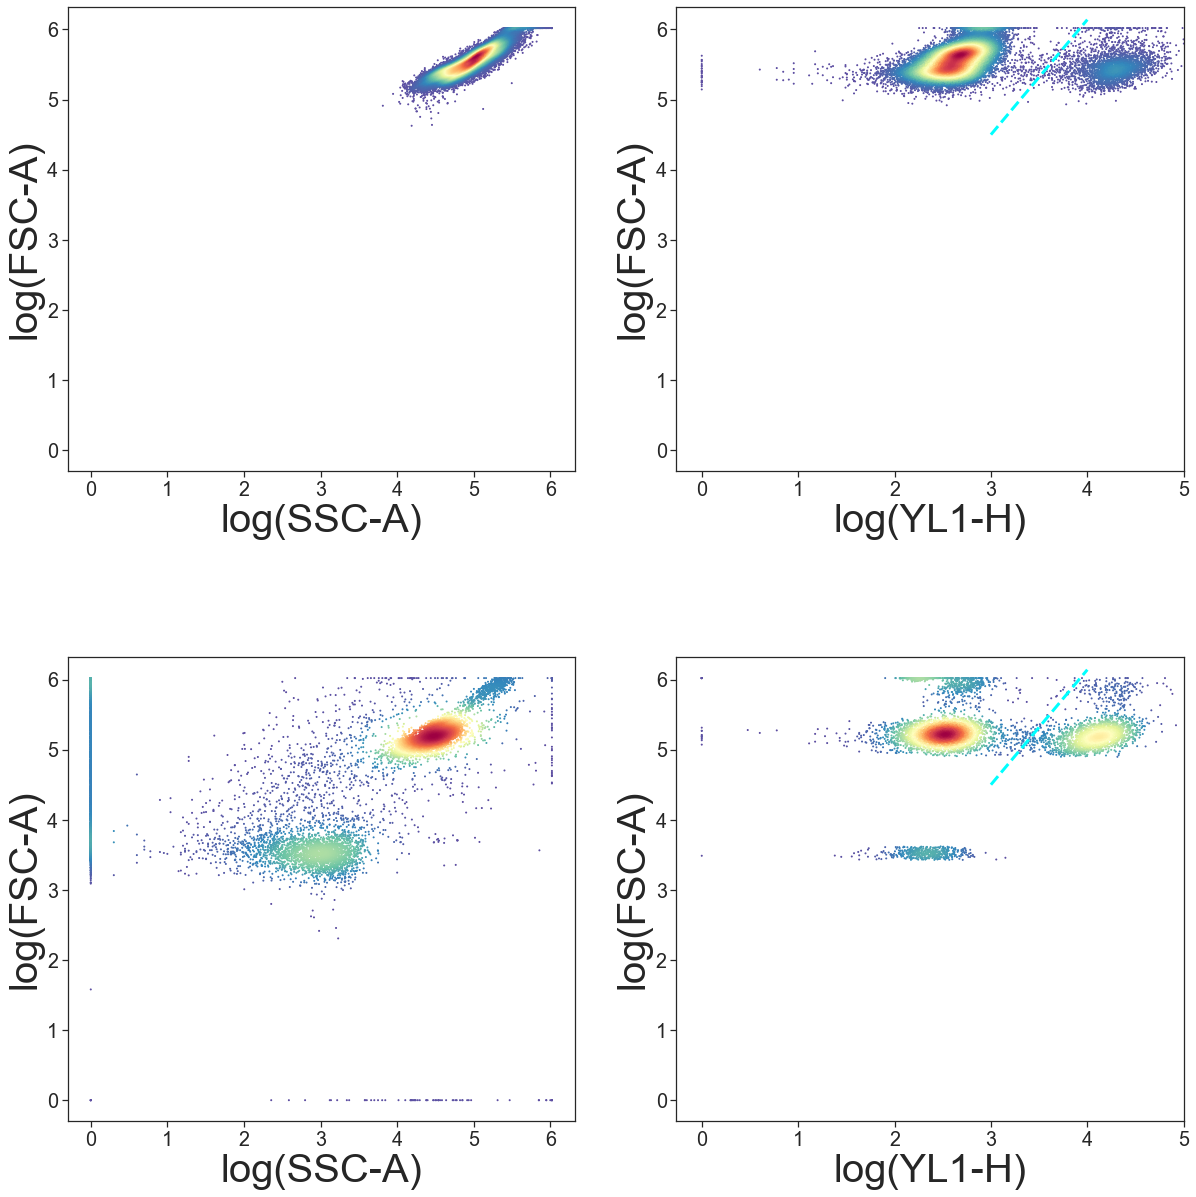

In [30]:
%matplotlib inline
kde_df, kde_df_sub = kde_scatter(conc_df_all, cc="YL1-H", logged=True, subset_ratio=0.85, 
                                 point_on_line_1=(3, 4.5), point_on_line_2=(4, 6.14),
                                 cmap="Spectral_r", pred_col="nn_preds", 
                                 pred_display_type="scatter_density")

# Calculate SOA_preds using visual line determined from above plots

In [20]:
kde_df["SOA_preds"] = 0

# get indices of points in kde_df_sub that are above the line drawn above
not_debris = kde_df_sub.loc[kde_df_sub["kmeans"] == 1]  # first need to get upper right ellipse in top-left plot
not_debris["SOA_line"] = 2.6923076923076925 * not_debris["log_YL1-H"] - 2.4615384615384617
not_debris["SOA_preds"] = (not_debris["log_FSC-A"] > not_debris["SOA_line"]).astype(int)
idxs = not_debris.loc[not_debris["SOA_preds"] == 1].index

kde_df.loc[idxs, "SOA_preds"] = 1

## Summary Table

In [21]:
summary_table = kde_df.groupby([n.inducer_concentration, n.timepoint], as_index=False).mean()

name_weakly = "Weakly Supervised Model (RF)"
name_cfu = "CFUs"
name_weakly_boosted = "AutoGater"
name_SOA = "State of the Art"

summary_table.rename(columns={"label": name_weakly, 
                              "cfu_percent_live": name_cfu,
                              "nn_preds": name_weakly_boosted,
                              "SOA_preds": name_SOA}, inplace=True)

summary_table = summary_table[[n.inducer_concentration, n.timepoint, 
                               name_weakly, name_cfu, name_weakly_boosted, name_SOA]]
summary_table = summary_table.loc[summary_table[n.timepoint].isin([0.5, 3.0, 6.0])]
summary_table[name_weakly] = (summary_table[name_weakly]*100).astype(int).astype(str) + "%"
summary_table[name_cfu] = summary_table[name_cfu].astype(int).astype(str) + "%"
summary_table[name_weakly_boosted] = (summary_table[name_weakly_boosted]*100).astype(int).astype(str) + "%"
summary_table[name_SOA] = (summary_table[name_SOA]*100).astype(int).astype(str) + "%"

summary_table[n.inducer_concentration] = summary_table[n.inducer_concentration].astype(str)
summary_table[n.timepoint] = summary_table[n.timepoint].astype(str)
# summary_table.to_csv("summary_table.csv", index=False)

summary_table_styled = summary_table.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
summary_table_styled.set_properties(**{'text-align': 'center'}).hide_index()

summary_table_styled

inducer_concentration,timepoint,Weakly Supervised Model (RF),CFUs,AutoGater,State of the Art
0.0,0.5,94%,100%,81%,0%
0.0,3.0,97%,93%,86%,0%
0.0,6.0,99%,93%,87%,0%
5.0,0.5,93%,62%,89%,0%
5.0,3.0,95%,89%,94%,0%
5.0,6.0,95%,82%,92%,0%
10.0,0.5,91%,90%,85%,0%
10.0,3.0,92%,72%,86%,0%
10.0,6.0,91%,63%,87%,0%
12.0,0.5,88%,69%,83%,0%


In [22]:
summary_table

,inducer_concentration,timepoint,Weakly Supervised Model (RF),CFUs,AutoGater,State of the Art
1,0.0,0.5,94%,100%,81%,0%
2,0.0,3.0,97%,93%,86%,0%
3,0.0,6.0,99%,93%,87%,0%
5,5.0,0.5,93%,62%,89%,0%
6,5.0,3.0,95%,89%,94%,0%
7,5.0,6.0,95%,82%,92%,0%
9,10.0,0.5,91%,90%,85%,0%
10,10.0,3.0,92%,72%,86%,0%
11,10.0,6.0,91%,63%,87%,0%
13,12.0,0.5,88%,69%,83%,0%


In [23]:
concat_summary_table = pd.concat([summary_table[["inducer_concentration",
                                                 "timepoint", "CFUs"]].assign(model='CFUs'), 
                                  summary_table[["inducer_concentration",
                                                 "timepoint", "AutoGater"]].assign(model='AutoGater'),
                                  summary_table[["inducer_concentration",
                                                 "timepoint", "State of the Art"]].assign(model='State of the Art')])
concat_summary_table.rename(columns={"CFUs": "percent"}, inplace=True)

concat_summary_table['percent'].update(concat_summary_table.pop('AutoGater'))
concat_summary_table['percent'].update(concat_summary_table.pop('State of the Art'))
concat_summary_table["timepoint"] = concat_summary_table["timepoint"].astype(float)
concat_summary_table["percent"] = concat_summary_table["percent"].str.rstrip('%').astype('float')

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/tkinter/__init__.py", line 1705, in __call__
    return self.func(*args)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/tkinter/__init__.py", line 749, in callit
    func(*args)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backends/_backend_tk.py", line 270, in idle_draw
    self.draw()
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backends/backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py", line 393, in draw
    self.figure.draw(self.renderer)
  File "/Users/he/anaconda3/envs/pysd2cat/lib/python3.6/site-packages/matplotlib/backend_bases.py", line 1556, in _draw
    def _draw(renderer): raise Done(renderer)
matplotlib.backend_bases._get_renderer.<locals>.Done

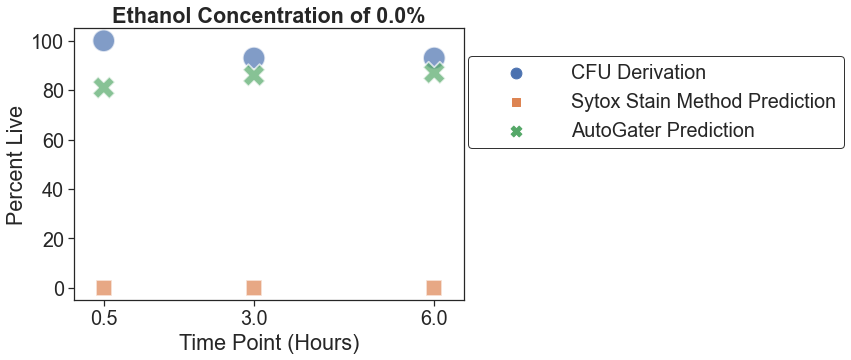

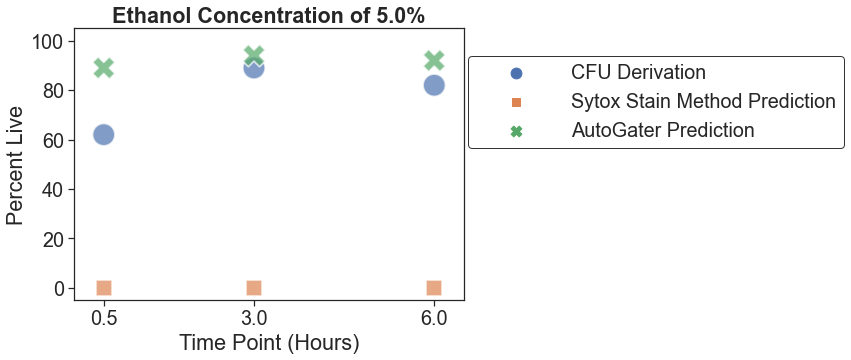

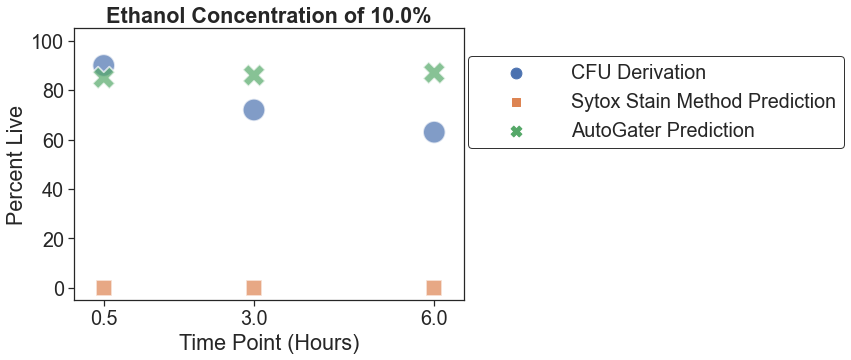

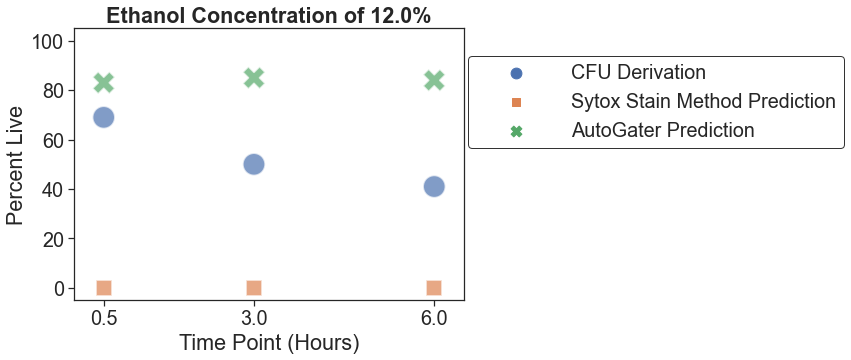

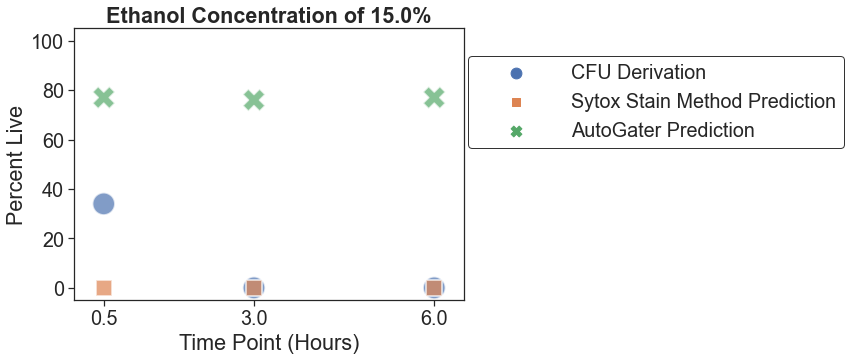

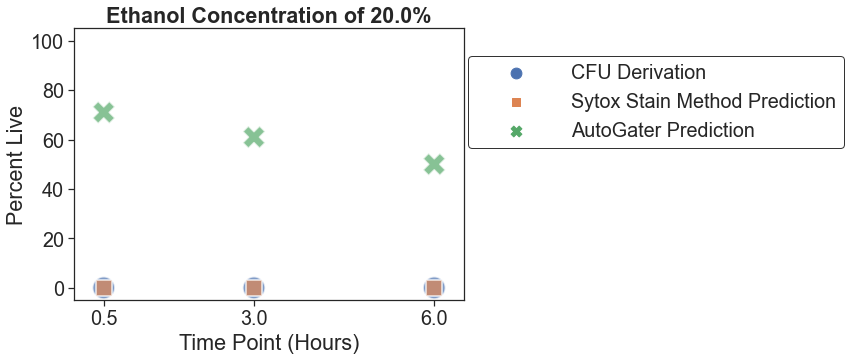

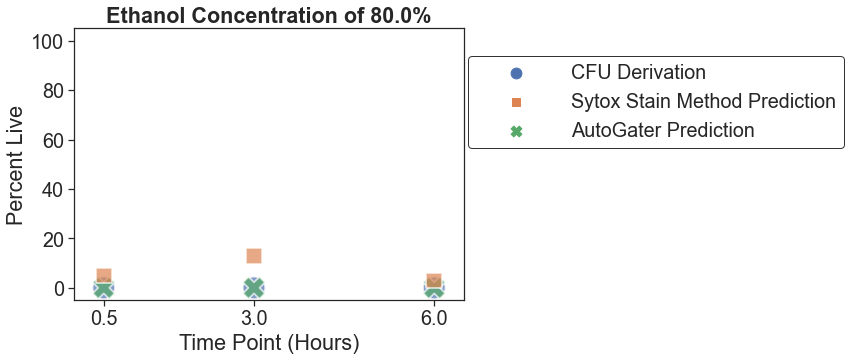

In [24]:
sns.set(style="ticks", font_scale=1.8, rc={"lines.linewidth": 3.0})

for c in [str(x) for x in list(concat_summary_table[n.inducer_concentration].unique())]:
    plt.figure(figsize=(7, 5))

    sc = sns.scatterplot(data=concat_summary_table.loc[concat_summary_table["inducer_concentration"] == c], 
                         x="timepoint", y="percent", s=500, alpha=.7, style="model",
                         hue="model", hue_order=["CFUs", "State of the Art", "AutoGater"], legend="full")

    legend = plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2, borderaxespad=0.,
                        handlelength=4, markerscale=1.8)
    legend.get_frame().set_edgecolor('black')
    new_labels = ['CFU Derivation', 'Sytox Stain Method Prediction', 'AutoGater Prediction']
    for t, l in zip(legend.texts, new_labels): t.set_text(l)

    sc.set(xlim=(0, 6.5), xlabel="Time Point (Hours)",
           ylim=(-5, 105), ylabel="Percent Live",
           xticks=[0.5, 3, 6])
    sc.set_title("Ethanol Concentration of {}%".format(c), fontweight="bold")
    plt.show()